In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

import pickle

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
preprocessed = pd.read_pickle('preprocessed.pkl')

links = pd.read_pickle('link_list.pkl')[:48]

# strain name filter

In [3]:
# after some EDA, the names of strains are showing up way too frequently
# we need to parse these out

names = []
for name in links:
    name = name.split('/')[2]
    name = name.split('-')
    for n in name:
        names.append(n)
names += ['girl', 'scout', 'cookie', 'gorilla', 'glue', 'strain']

name_filtered = []
for strain in preprocessed:
    check = ''
    for word in strain.split():
        if word not in names:
            check += word + ' '
    name_filtered.append(check)

# TF-IDF and NMF

In [4]:
df = pd.DataFrame(data = name_filtered, index = [link.split('/')[2] for link in links])
df.head()

,0
blue-dream,friend stoner redey countryman lend ear bring ...
sour-diesel,ideal god get anti depressant find smoke happy...
gsc,favorite daily user effect strong intense enjo...
green-crack,good hand know provide effect veteran consumer...
og-kush,nug dark massive fairly dense piney chocolate ...


In [5]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [6]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.6, min_df = 3, stop_words = 'english', ngram_range = (2,2))
tfidf = tfidf_vectorizer.fit_transform(name_filtered)

In [7]:
pickle_out = open('tfidf.pkl', 'wb')
pickle.dump(tfidf, pickle_out)
pickle_out.close()

In [8]:
tfidf_vectorizer.get_feature_names()[:5]

['able calm', 'able eat', 'able enjoy', 'able finish', 'able focus']

In [9]:
nmf = NMF(n_components = 4, random_state = 42, alpha = 0, l1_ratio = 0).fit(tfidf)

In [10]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
display_topics(nmf, tfidf_feature_names, 10)


Topic  0
sativa dominant, start day, anxiety depression, make want, sativa high, strong sativa, wake bake, great day, great sativa, definitely recommend

Topic  1
night time, fall asleep, body stone, night sleep, great pain, strong body, great night, pure indica, heavy indica, listen music

Topic  2
nerve pain, strong indica, head body, body relaxation, glass pipe, good representation, happy high, taste sweet, high munchie, taste delicious

Topic  3
chronic pain, high cbd, like train, creative mind, hit like, good time, enjoy company, effect uplift, good high, enjoy high


In [12]:
nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [12]:
pickle_out = open('nmf.pkl', 'wb')
pickle.dump(nmf_embedding, pickle_out)
pickle_out.close()

In [13]:
topics = ['daytime, anxiety, depression',
          'nighttime, insomnia',
          'happy feelings, nerve pain',
          'creativity, chronic pain']

# Weed Clouds

In [49]:
from wordcloud import WordCloud
from PIL import Image
from collections import defaultdict

In [15]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(100, {}%, {}%)".format(np.random.randint(50,100),np.random.randint(5,35))

In [115]:
def make_cloud(text_list, link):
    
    mask = np.array(Image.open(link))
    
    text = ' '.join(text_list)
    wordcloud = WordCloud(background_color = "white",
                          collocations = False,
                          height = 200,
                          width = 200,
                          min_font_size = 8,
                          max_font_size = 50,
                          relative_scaling=0,
                          mask = mask)
    wordcloud.generate(text)
    wordcloud.recolor(color_func=grey_color_func, random_state=42)
    
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

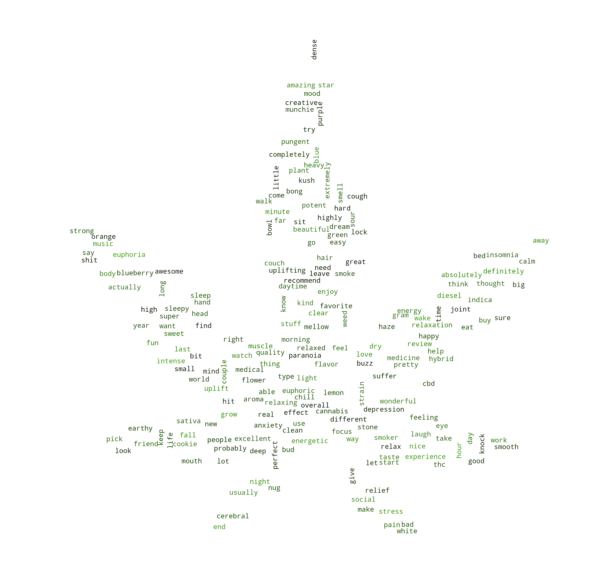

In [116]:
make_cloud(preprocessed, 'leaf.jpg')

In [82]:
def simple_cloud(text_list):
        
    text = ' '.join(text_list)
    wordcloud = WordCloud(background_color = "white",
                          collocations = False,
                          height = 300,
                          width = 300,
                          min_font_size = 2,
                          max_font_size = 50,
                          relative_scaling = 0
                         )
    wordcloud.generate(text)
    wordcloud.recolor(color_func=grey_color_func, random_state=42)
    
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

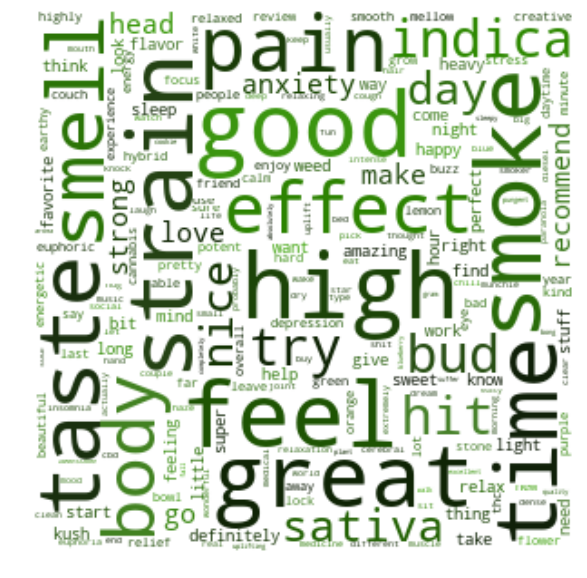

In [83]:
simple_cloud(preprocessed)

In [145]:
def gram_freq(n_grams, count_matrix):
    
    n_gram_frequency = defaultdict(dict)
    
    for i, n_gram in enumerate(n_grams):
        count = np.sum(count_matrix[:,i])
        n_gram_frequency[n_gram] = float(count)
    
    return n_gram_frequency

In [89]:
count_vectorizer = CountVectorizer(max_df = 0.6, min_df = 3, stop_words = 'english', ngram_range = (2,2))
count = count_vectorizer.fit_transform(name_filtered)

In [146]:
dd = gram_freq(tfidf_feature_names, count)

In [132]:
list(dd.keys())

'able calm'

In [133]:
def dict_cloud(text_dict):
        
    wordcloud = WordCloud(background_color = "white",
                          collocations = False,
                          height = 300,
                          width = 300,
                          min_font_size = 2,
                          max_font_size = 50,
                          relative_scaling = 0
                         )
    wordcloud.generate_from_frequencies(text_dict)
    wordcloud.recolor(color_func=grey_color_func, random_state=42)
    
    plt.figure(figsize = (10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

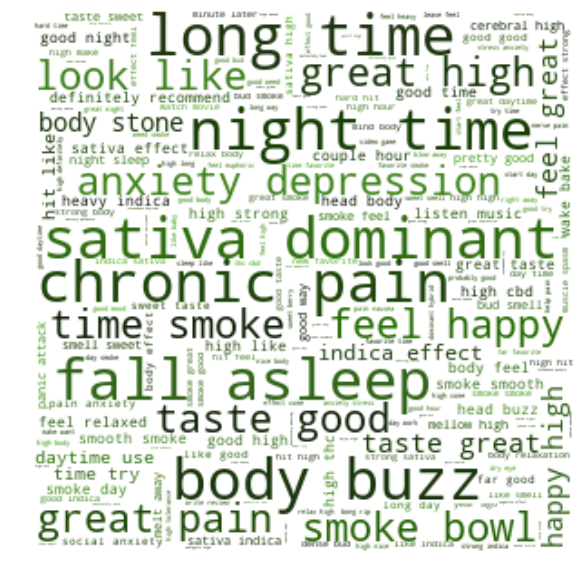

In [147]:
dict_cloud(dict(dd))

In [143]:
len(dict(dd).items())

4154

In [13]:
nmf_embedding

array([[ 7.99081337e-01, -3.22863867e-01, -1.86721428e-01,
         6.50917176e-02],
       [ 2.18446641e+00, -7.72677652e-01, -5.43919020e-01,
        -6.39827213e-01],
       [ 3.53582016e-01, -7.25244395e-01,  1.21421104e+00,
        -6.39827213e-01],
       [ 1.88226520e+00, -7.72677652e-01, -5.43919020e-01,
        -6.39827213e-01],
       [-6.01878377e-01, -3.29709337e-01,  7.43777233e-01,
         3.63141439e-01],
       [-8.17123552e-01,  1.71143248e+00, -1.59676619e-01,
        -4.17019328e-01],
       [ 1.49856459e+00, -4.88471697e-01, -5.43919020e-01,
        -6.39827213e-01],
       [-8.39433574e-01, -7.72677652e-01, -5.43919020e-01,
         2.52214535e+00],
       [ 1.73143048e-02,  9.37788753e-01, -5.43919020e-01,
        -5.52824421e-01],
       [-8.39433574e-01,  1.85158394e+00, -5.43919020e-01,
        -6.39827213e-01],
       [ 1.30536771e+00, -7.72677652e-01, -1.12612931e-01,
        -6.39827213e-01],
       [-6.12122212e-01,  1.16055210e+00, -1.64145326e-01,
      